In [1]:
# --- Общие импорты и настройка ---
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
!pip install torch torchvision matplotlib scikit-learn kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 327.9/664.8 MB 4.9 MB/s eta 0:01:10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone m

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belka9236","key":"bfd24af8db09c20a1994061122c91fe5"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d brsdincer/eyes-image-dataset-for-machine-learning -p /content/
!unzip /content/eyes-image-dataset-for-machine-learning.zip -d /content/


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/eyes data/s0037/s0037_05259_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05260_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05261_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05262_1_1_0_0_1_01.png  
  inflating: /content/eyes data/s0037/s0037_05263_1_1_0_0_1_01.png  
  inflating: /content/eyes data/s0037/s0037_05264_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05265_1_1_0_0_1_01.png  
  inflating: /content/eyes data/s0037/s0037_05266_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05267_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05268_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05269_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05270_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s0037/s0037_05271_1_1_0_0_0_01.png  
  inflating: /content/eyes data/s00

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Загрузка данных и разделение по классам ---
DATA_DIR = '/content/eyes data'


# Базовый Dataset: предполагается структура: /content/eyes data/<person_id>/image.jpg
class EyesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # список кортежей (путь к изображению, label)
        for person in os.listdir(root_dir):
            person_dir = os.path.join(root_dir, person)
            if os.path.isdir(person_dir):
                for img_name in os.listdir(person_dir):
                    img_path = os.path.join(person_dir, img_name)
                    self.samples.append((img_path, person))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Определяем трансформации для изображений (под ResNet50)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Создаем базовый датасет
base_dataset = EyesDataset(root_dir=DATA_DIR, transform=transform)

# Разделяем по уникальным меткам (человекам) для предотвращения утечки
all_labels = list(set([label for _, label in base_dataset.samples]))
train_labels, test_labels = train_test_split(all_labels, test_size=0.15, random_state=42)
train_labels, val_labels = train_test_split(train_labels, test_size=0.176, random_state=42)  # ≈15% для валидации

def filter_samples(labels_to_keep):
    return [(img, label) for img, label in base_dataset.samples if label in labels_to_keep]

train_samples = filter_samples(train_labels)
val_samples = filter_samples(val_labels)
test_samples = filter_samples(test_labels)

# --- Определяем Siamese Dataset (формирование пар) ---
class SiameseEyesDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        # Группируем пути по меткам
        self.label_to_imgs = {}
        for img, label in samples:
            self.label_to_imgs.setdefault(label, []).append(img)
        self.labels = list(self.label_to_imgs.keys())

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img1_path, label1 = self.samples[idx]
        img1 = Image.open(img1_path).convert('RGB')
        if self.transform:
            img1 = self.transform(img1)
        # Случайный выбор: положительная пара или отрицательная
        if random.randint(0, 1) == 1:
            # Положительная пара: выбираем из того же класса
            img2_path = random.choice(self.label_to_imgs[label1])
            pair_label = 0  # 0 означает "одинаковые"
        else:
            # Отрицательная пара: выбираем из другого класса
            label2 = random.choice([l for l in self.labels if l != label1])
            img2_path = random.choice(self.label_to_imgs[label2])
            pair_label = 1  # 1 означает "разные"
        img2 = Image.open(img2_path).convert('RGB')
        if self.transform:
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(pair_label, dtype=torch.float32)

# Создаем DataLoader-ы для train, validation и test
train_siamese_dataset = SiameseEyesDataset(train_samples, transform=transform)
val_siamese_dataset = SiameseEyesDataset(val_samples, transform=transform)
test_siamese_dataset = SiameseEyesDataset(test_samples, transform=transform)

train_loader = DataLoader(train_siamese_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_siamese_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_siamese_dataset, batch_size=32, shuffle=False)




In [7]:
# --- Определяем модель Siamese Network ---
# Используем предобученную ResNet50 и заменяем последний слой на Identity, чтобы получать эмбеддинги.
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)

class SiameseNetwork(nn.Module):
    def __init__(self, backbone):
        super(SiameseNetwork, self).__init__()
        self.backbone = backbone

    def forward(self, x1, x2):
        out1 = self.backbone(x1)
        out2 = self.backbone(x2)
        return out1, out2

siamese_model = SiameseNetwork(resnet).to(device)

# --- Определяем функцию потерь Contrastive Loss ---
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Вычисляем евклидово расстояние между эмбеддингами
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        # Если пары одинаковые (label=0), стремимся минимизировать расстояние;
        # если разные (label=1) – расстояние должно быть не меньше margin.
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(siamese_model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


Epoch [1/3] Train Loss: 0.7456  Val Loss: 0.1081
Epoch [2/3] Train Loss: 0.0786  Val Loss: 0.1340
Epoch [3/3] Train Loss: 0.0443  Val Loss: 0.1109


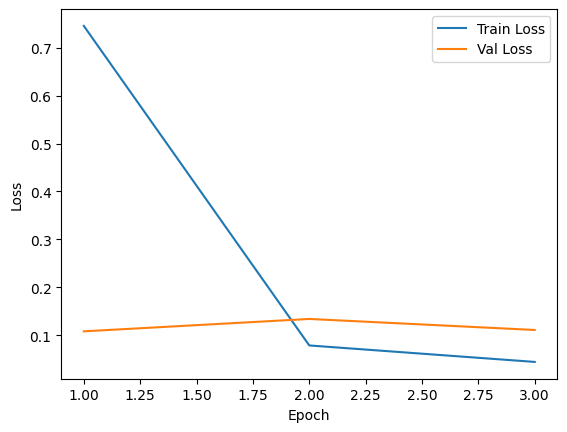

Best threshold on validation: 0.5887 with accuracy: 0.8824
Test Accuracy: 0.8345
Test ROC AUC: 0.9109


In [8]:
# --- Обучение и валидация ---
num_epochs = 3
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    # Тренировочная фаза
    siamese_model.train()
    running_loss = 0.0
    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2 = siamese_model(img1, img2)
        loss = criterion(out1, out2, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * img1.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Валидация
    siamese_model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            out1, out2 = siamese_model(img1, img2)
            loss = criterion(out1, out2, labels)
            val_running_loss += loss.item() * img1.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

# Визуализация кривых потерь
plt.plot(range(1, num_epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Определение порогового значения на валидационном наборе ---
val_distances = []
val_labels_list = []
siamese_model.eval()
with torch.no_grad():
    for img1, img2, labels in val_loader:
        img1, img2 = img1.to(device), img2.to(device)
        out1, out2 = siamese_model(img1, img2)
        distances = nn.functional.pairwise_distance(out1, out2)
        val_distances.extend(distances.cpu().numpy())
        val_labels_list.extend(labels.cpu().numpy())

val_distances = np.array(val_distances)
val_labels_list = np.array(val_labels_list)

# Подбираем оптимальный порог, перебирая возможные значения
thresholds = np.linspace(val_distances.min(), val_distances.max(), 100)
best_thresh = thresholds[0]
best_acc = 0.0
for thresh in thresholds:
    preds = (val_distances > thresh).astype(int)  # если расстояние > порога, предсказываем "разные" (1)
    acc = np.mean(preds == val_labels_list)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh
print(f"Best threshold on validation: {best_thresh:.4f} with accuracy: {best_acc:.4f}")

# --- Тестирование ---
test_distances = []
test_labels_list = []
siamese_model.eval()
with torch.no_grad():
    for img1, img2, labels in test_loader:
        img1, img2 = img1.to(device), img2.to(device)
        out1, out2 = siamese_model(img1, img2)
        distances = nn.functional.pairwise_distance(out1, out2)
        test_distances.extend(distances.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())
test_distances = np.array(test_distances)
test_labels_list = np.array(test_labels_list)

test_preds = (test_distances > best_thresh).astype(int)
test_acc = np.mean(test_preds == test_labels_list)
print(f"Test Accuracy: {test_acc:.4f}")
try:
    roc_auc = roc_auc_score(test_labels_list, test_distances)
    print(f"Test ROC AUC: {roc_auc:.4f}")
except Exception as e:
    print("ROC AUC calculation failed:", e)




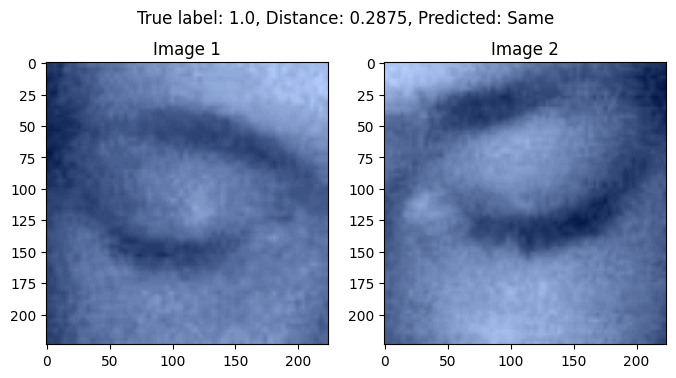

In [15]:
# --- Демонстрация работы на случайной паре из теста ---
def show_pair_prediction(dataset, model, threshold, idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset)-1)
    img1, img2, label = dataset[idx]
    model.eval()
    with torch.no_grad():
        out1, out2 = model(img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device))
        dist = nn.functional.pairwise_distance(out1, out2).item()
    pred = 0 if dist < threshold else 1
    img1_np = img1.permute(1,2,0).cpu().numpy()
    img2_np = img2.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow((img1_np - img1_np.min()) / (img1_np.max()-img1_np.min()))
    plt.title("Image 1")
    plt.subplot(1,2,2)
    plt.imshow((img2_np - img2_np.min()) / (img2_np.max()-img2_np.min()))
    plt.title("Image 2")
    plt.suptitle(f"True label: {label}, Distance: {dist:.4f}, Predicted: {'Same' if pred==0 else 'Different'}")
    plt.show()

show_pair_prediction(test_siamese_dataset, siamese_model, best_thresh)